# Bioethanol production in Brazil

### Downloading the data

In [1]:
# Un-comment to download spreadsheets to data folder
#import requests, zipfile, io
#r = requests.get('https://www.gov.br/anp/pt-br/assuntos/producao-e-fornecimento-de-biocombustiveis/etanol/arquivos-etanol/pb-da-etanol.zip')
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall(path='./data/')

### Reading the data

In [2]:
from pathlib import Path
import csv

In [3]:
# File containing production capacity per plant site
path = Path('./data/Etanol_DadosAbertos_CSV_Capacidade.csv')
lines = path.read_text(encoding='utf-8').splitlines()

reader = csv.reader(lines)
header_row = next(reader)

In [4]:
print("Column names:")
for i, name in enumerate(header_row):
    print(f"{i}: {name}")

Column names:
0: ﻿Mês/Ano
1: Razão Social
2: CNPJ
3: Região
4: Estado
5: Município
6: Capacidade Produção Etanol Anidro (m³/d)
7: Capacidade Produção Etanol Hidratado (m³/d)


Note: A CNPJ, or Cadastro Nacional de Pessoa Jurídica, is a unique tax identification number given to entities such as companies, partnerships, foundations and in this case, plant sites. Each plant site has its own unique CNPJ. This means that a company with multiple plants will have multiple CNPJs with a different number for each site.

In [5]:
import pandas as pd

In [6]:
date_format = '%m/%Y'

In [7]:
dates = []
names = []
cnpjs = []
states = []
capacities_anhydrous = []
capacities_hydrous = []


for row in reader:
    date = pd.to_datetime(row[0], format=date_format)
    name = row[1]
    cnpj = int(row[2])
    state = row[4]
    capacity_anhydrous = int(row[6])
    capacity_hydrous = int(row[7])

    dates.append(date)
    names.append(name)
    cnpjs.append(cnpj)
    states.append(state)
    capacities_anhydrous.append(capacity_anhydrous)
    capacities_hydrous.append(capacity_hydrous)

In [8]:
df = pd.DataFrame({'date': dates,
                   'name': names,
                   'cnpj': cnpjs,
                   'state': states,
                   'capacity_hydrous': capacities_hydrous,
                   'capacity_anhydrous': capacities_anhydrous})

In [9]:
df.head()

,date,name,cnpj,state,capacity_hydrous,capacity_anhydrous
0,2024-11-01,CARAMURU ALIMENTOS S/A,80671002668,Mato Grosso,50,0
1,2024-11-01,DESTILARIA DE ÁLCOOL LIBRA LTDA - EM RECUPERAÇ...,297598000122,Mato Grosso,600,600
2,2024-11-01,CENTRAL ENERGETICA VALE DO SAPUCAI LTDA,372496000124,São Paulo,900,517
3,2024-11-01,DENUSA DESTILARIA NOVA UNIAO S/A - EM RECUPERA...,595322000120,Goiás,650,450
4,2024-11-01,SANTA CRUZ ACUCAR E ALCOOL LTDA,738822000255,Bahia,240,200


### Exploring the data

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def get_most_recent_record(df,cnpj):
    return df[df['cnpj']==cnpj].to_dict('records')[0]

In [12]:
def get_subset_for_last_records_of_the_year(df,year):

    df_subset = df[(df['date'].dt.year > year-1) & (df['date'].dt.year < year+1)]
    unique_cnpj_list = df_subset['cnpj'].unique().tolist()

    for cnpj in unique_cnpj_list:
        date = get_most_recent_record(df_subset,cnpj)['date']
        df_subset = df_subset[~((df_subset['date']!=date) & (df_subset['cnpj']==cnpj))]

    return df_subset

In [13]:
def get_label_colors(bar_labels):

    bar_colors = []

    for label in bar_labels:
        if 'INPASA' in label:
            bar_colors.append('tab:red')
        elif 'FS ' in label:
            bar_colors.append('tab:blue')
        elif 'RAIZEN' in label:
            bar_colors.append('tab:orange')
        elif 'SAO MARTINHO' in label:
            bar_colors.append('tab:olive')
        elif 'TROPICAL' in label:
            bar_colors.append('tab:purple')
        elif 'ATVOS' in label:
            bar_colors.append('tab:green')
        else:
            bar_colors.append('tab:gray')

    return bar_colors

In [14]:
def subplot_bar_chart_capacities(ax,col_name,df,Nvals):

    xvals = np.arange(1,Nvals+1,1)
    yvals = df.sort_values(by=[col_name], ascending=False)[col_name].head(Nvals)

    bar_labels = get_labels(df,col_name,Nvals)
    bar_colors = get_label_colors(bar_labels)

    bar_chart = ax.bar(xvals , yvals, label = bar_labels, color = bar_colors)
    ax.bar_label(bar_chart, label_type='center')
    ax.legend(title='Key',fontsize=8)
    ax.set_title(col_name.replace('_',' '),fontsize=10)
    ax.set_xticks(xvals)
    ax.set_xlabel('Rank', fontsize=14)
    ax.set_ylabel('Production capacity (m³/day)', fontsize=14)


In [15]:
def get_labels(df, col_name, Nvals):

    bar_labels = df.sort_values(by=[col_name], ascending=False)['name'].head(Nvals).tolist()

    labels = []
    for i, name in enumerate(bar_labels,start=1):
        labels.append(f"{i}: {name}")

    return labels

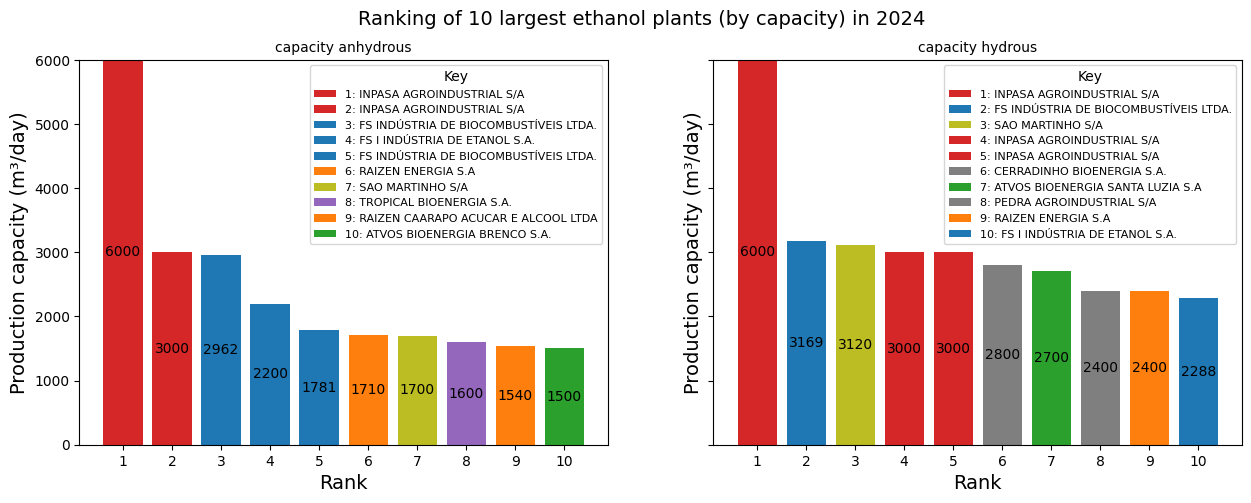

In [16]:
# Define year and top Nvals number of plants to rank
year = 2024
Nvals = 10

# Filters data for specified year
df_year = get_subset_for_last_records_of_the_year(df,year)

# Plots 2 bar charts side by side for hydrous and anhydrous ethanol
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
fig.suptitle(f"Ranking of {Nvals} largest ethanol plants (by capacity) in {year}", fontsize=14)
subplot_bar_chart_capacities(ax1,'capacity_anhydrous',df_year,Nvals)
subplot_bar_chart_capacities(ax2,'capacity_hydrous',df_year,Nvals)
plt.ylim(0, 6000)
plt.show()

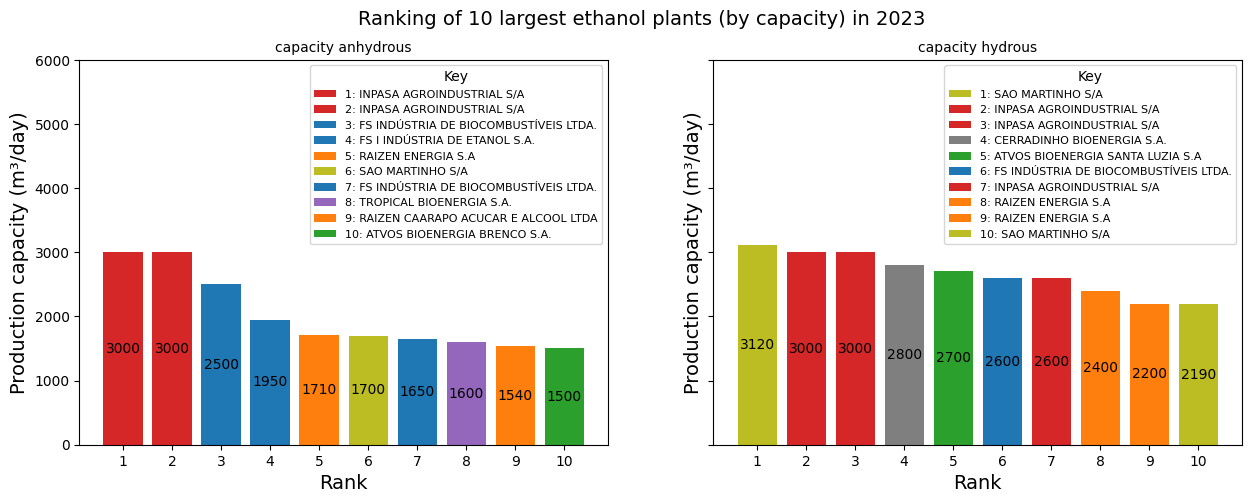

In [17]:
# Define year and top Nvals number of plants to rank
year = 2023
Nvals = 10

# Filters data for specified year
df_year = get_subset_for_last_records_of_the_year(df,year)

# Plots 2 bar charts side by side for hydrous and anhydrous ethanol
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
fig.suptitle(f"Ranking of {Nvals} largest ethanol plants (by capacity) in {year}", fontsize=14)
subplot_bar_chart_capacities(ax1,'capacity_anhydrous',df_year,Nvals)
subplot_bar_chart_capacities(ax2,'capacity_hydrous',df_year,Nvals)
plt.ylim(0, 6000)
plt.show()

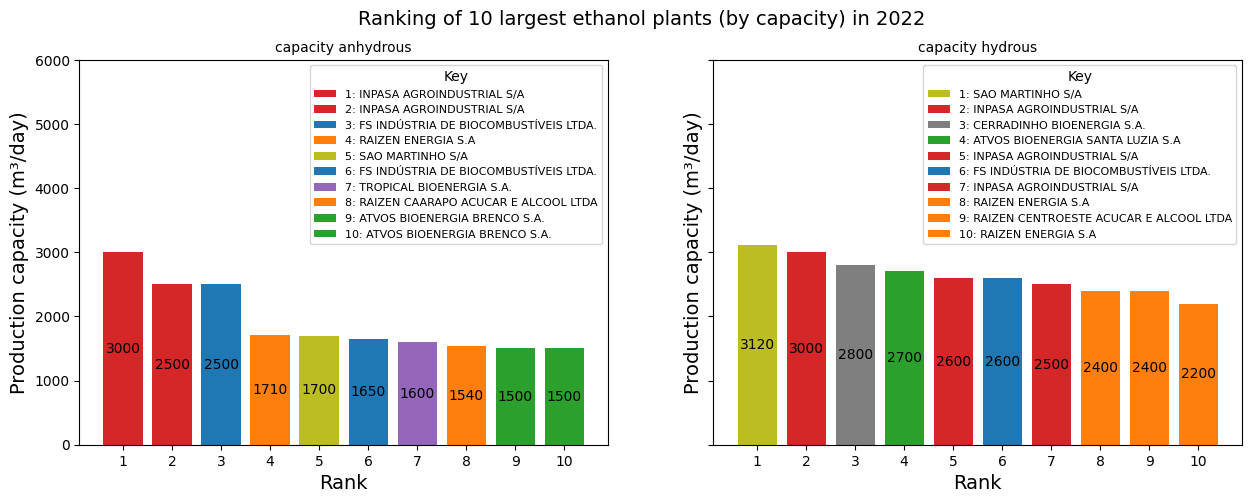

In [18]:
# Define year and top Nvals number of plants to rank
year = 2022
Nvals = 10

# Filters data for specified year
df_year = get_subset_for_last_records_of_the_year(df,year)

# Plots 2 bar charts side by side for hydrous and anhydrous ethanol
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
fig.suptitle(f"Ranking of {Nvals} largest ethanol plants (by capacity) in {year}", fontsize=14)
subplot_bar_chart_capacities(ax1,'capacity_anhydrous',df_year,Nvals)
subplot_bar_chart_capacities(ax2,'capacity_hydrous',df_year,Nvals)
plt.ylim(0, 6000)
plt.show()

### Create dataframe for ribbon chart

Next steps:
- fill in missing values
- refactor last section
- sort in ascending order of 2024 column
- create dataframe for anhydrous data
- create ribbon chart

In [25]:
# Define year and top Nvals number of plants to rank
year = 2020
Nvals = 10

# Filters data for specified year
df_year = get_subset_for_last_records_of_the_year(df,year)
N = df_year.index.size

In [26]:
col_name = 'capacity_hydrous'
df_hydrous = df_year.sort_values(by=[col_name], ascending=False)
df_hydrous.drop(['date','state','capacity_anhydrous'], axis=1, inplace=True)
df_hydrous.rename(columns={'capacity_hydrous':str(year)}, inplace=True)
df_hydrous  = df_hydrous.set_index(np.arange(N)).head(Nvals)

In [27]:
for year in range(2021,2025):

    # Filters data for specified year
    df_year = get_subset_for_last_records_of_the_year(df,year)
    N = df_year.index.size

    col_name = 'capacity_hydrous'
    df_hydrous_temp = df_year.sort_values(by=[col_name], ascending=False)
    df_hydrous_temp.drop(['date','state','capacity_anhydrous'], axis=1, inplace=True)
    df_hydrous_temp.rename(columns={'capacity_hydrous':str(year)}, inplace=True)
    df_hydrous_temp  = df_hydrous_temp.set_index(np.arange(N)).head(Nvals)

    df_hydrous = pd.merge(df_hydrous, df_hydrous_temp[['cnpj',str(year)]], how='outer', on='cnpj')

df_hydrous

,name,cnpj,2020,2021,2022,2023,2024
0,IACO AGRICOLA S/A,7895728000682,2100.0,NaN,NaN,NaN,NaN
1,RAIZEN ENERGIA S.A,8070508000330,2200.0,2200.0,2200.0,2200.0,NaN
2,NaN,8070508016767,NaN,NaN,2400.0,2400.0,2400.0
3,TROPICAL BIOENERGIA S.A.,8195806000194,2100.0,NaN,NaN,NaN,NaN
4,CERRADINHO BIOENERGIA S.A.,8322396000103,2800.0,2800.0,2800.0,2800.0,2800.0
5,RAIZEN CENTROESTE ACUCAR E ALCOOL LTDA,8619844000399,2400.0,2400.0,2400.0,NaN,NaN
6,ATVOS BIOENERGIA SANTA LUZIA S.A,8906558000142,2700.0,2700.0,2700.0,2700.0,2700.0
7,RAIZEN CAARAPO ACUCAR E ALCOOL LTDA,9538989000166,2100.0,2100.0,NaN,NaN,NaN
8,NaN,20003699000231,NaN,2600.0,2600.0,2600.0,3169.0
9,NaN,29316596000115,NaN,3000.0,3000.0,3000.0,6000.0
